In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json._normalize import nested_to_record
import json, wandb
from omegaconf import OmegaConf

%matplotlib inline

## gather data df

In [2]:
pull_from_wandb = False

if pull_from_wandb:
    username = "lavender"
    project_name = "eval_threshold"
    api = wandb.Api()

    def artifact_to_df(artifact):
        local_path = artifact.file()
        f = open(local_path)
        data = json.load(f)
        df = pd.DataFrame(data=data["data"], columns=data["columns"])
        return df

    def combine(
        trials=["temporal", "prospective", "random"],
        metrics=["fpr", "tpr"],
        artifact_names=[
            "new_temporal_auc_curve",
            "prospective_auc",
            "new_random_test_auc_curve",
        ],
    ):
        dfs = []
        subs = []
        for artifact_name in artifact_names:
            artifact = api.artifact(f"{username}/{project_name}/{artifact_name}:v0")
            df = artifact_to_df(artifact)
            dfs.append(df)
        for idx, artifact_df in enumerate(dfs):
            print(artifact_df)
            df_sub = artifact_df[metrics]
            df_sub["trial"] = trials[idx]
            print(df_sub)
            subs.append(df_sub)
        combined = pd.concat(subs, ignore_index=True)
        return combined

    combined = combine()
    df_plot = combined[combined.trial.isin(["temporal", "random"])]
    df_plot["trial"] = df_plot["trial"].replace(
        {"random": "random-split", "temporal": "temporal-split"}
    )
    df_plot["trial"] = pd.Categorical(
        df_plot["trial"], categories=["random-split", "temporal-split"]
    )
    df_plot = df_plot.sort_values(by="trial")
    df_plot.to_csv("raw_data/4a_auc.csv")


else:
    df_plot = pd.read_csv("raw_data/4a_auc.csv", index_col=0)

In [3]:
plt_conf = OmegaConf.load("nature.yaml")
slack = 5
single_col_width = 89 - slack
double_col_width = 183 - slack
height = 89 - slack


def mm_to_inch(mm):
    return mm / 25.4


print(plt_conf)

{'axes.labelsize': 7, 'xtick.labelsize': 7, 'ytick.labelsize': 7, 'legend.fontsize': 7, 'font.size': 7, 'font.family': 'sans-serif', 'font.sans-serif': 'Arial, Helvetica', 'mathtext.fontset': 'dejavusans', 'axes.linewidth': 0.5, 'grid.linewidth': 0.5, 'lines.linewidth': 1.0, 'lines.markersize': 3, 'pdf.fonttype': 42, 'ps.fonttype': 42, 'svg.fonttype': 'none'}


/var/folders/5v/561pm5gx1h9fgr_77mp6091m0000gn/T/ipykernel_18853/1272353011.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(x='fpr', y='tpr', data=df_plot, hue='trial', palette=['purple'], ci=100)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


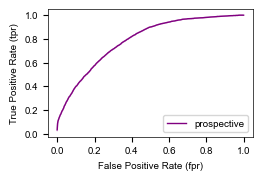

In [8]:
plt.rcParams.update(plt_conf)
plt.rcParams["figure.figsize"] = (
    mm_to_inch(single_col_width * 4 / 5),
    mm_to_inch(height / 2),
)
sns.lineplot(x="fpr", y="tpr", data=df_plot, hue="trial", palette=["purple"], ci=100)
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate (fpr)")
plt.ylabel("True Positive Rate (tpr)")
plt.savefig(
    "AIP_plots/4a_auc.pdf", bbox_inches="tight", dpi=300, transparent=True, format="pdf"
)
plt.savefig("AIP_plots/4a_auc.svg", bbox_inches="tight", format="svg")
plt.savefig(
    "AIP_plots/4a_auc.eps", bbox_inches="tight", dpi=300, transparent=True, format="eps"
)